# Basic examples

In this notebook we will show how to compute power spectra with local or global line-of-sight, how to dump them to disk, etc.
You need to have installed **pypower** with:
```
python -m pip install git+https://github.com/cosmodesi/pypower#egg=pypower[extras]
```
(extras include sympy and numexpr for faster spherical harmonics)

In [1]:
import os
import tempfile

import numpy as np
from matplotlib import pyplot as plt

from pypower import CatalogMesh, MeshFFTPower, CatalogFFTPower, PowerSpectrumStatistics, utils, setup_logging

# To activate logging
setup_logging()

In [2]:
def generate_catalogs(size=10000, boxsize=(1000,)*3, offset=(1000.,0,0), seed=42):
    rng = np.random.RandomState(seed=seed)
    toret = []
    for i in range(2):
        positions = [o + rng.uniform(0., 1., size)*b for o,b in zip(offset,boxsize)]
        weights = rng.uniform(0.5, 1., size)
        toret.append((positions, weights))
    return toret

In [3]:
# First, generate fake data with cartesian positions and weights
(data_positions1, data_weights1), (data_positions2, data_weights2) = generate_catalogs(size=10000, seed=42)
(randoms_positions1, randoms_weights1), (randoms_positions2, randoms_weights2) = generate_catalogs(size=50000, seed=84)

## High-level interface
Here we use the high-level interface, starting from the catalogs directly.

In [4]:
# Compute the cross-power spectrum multipoles of order (0, 2, 4), with 10 bins between 0 and 0.2
# using local line-of-sight, box physical size of 2000, mesh size of 256^3, TSC assignment scheme,
# interlacing correction (2nd order)
# los can be None (local) or any box axis ('x', 'y', 'z') or 3-vecto
# Input positions, weights are gathered (not MPI-scattered), so we tell CatalogFFTPower
# to take positions and weights from rank 0 (mpiroot = 0)
kedges = np.linspace(0, 0.2, 11)
ells = (0, 2, 4)
result = CatalogFFTPower(data_positions1=data_positions1, data_weights1=data_weights1,
                         data_positions2=data_positions2, data_weights2=data_weights2,
                         randoms_positions1=randoms_positions1, randoms_weights1=randoms_weights1,
                         randoms_positions2=randoms_positions2, randoms_weights2=randoms_weights2,
                         edges=kedges, ells=ells, interlacing=2, boxsize=2000., nmesh=128, resampler='tsc',
                         los=None, position_type='xyz', mpiroot=0)
# Note that you can also provide single data/randoms catalogs (auto-correlation),
# no randoms (uniform selection function), no weights (assumed unity)

[000000.19]  07-07 09:46  CatalogFFTPower              INFO     Painting catalog 1 to mesh CatalogMesh(nmesh=[128 128 128], boxsize=[2000. 2000. 2000.], boxcenter=[1499.9920812   499.99200437  499.99818966], dtype=float64).
[000000.21]  07-07 09:46  CatalogMesh                  INFO     Slab 0 ~ 4194304 / 10000.
[000000.30]  07-07 09:46  CatalogMesh                  INFO     Painted 10000 out of 10000 objects to mesh.
[000000.31]  07-07 09:46  CatalogMesh                  INFO     Slab 0 ~ 4194304 / 50000.
[000000.44]  07-07 09:46  CatalogMesh                  INFO     Painted 50000 out of 50000 objects to mesh.
[000000.44]  07-07 09:46  CatalogMesh                  INFO     Running interlacing at order 2.
[000000.54]  07-07 09:46  CatalogMesh                  INFO     Slab 0 ~ 4194304 / 10000.
[000000.60]  07-07 09:46  CatalogMesh                  INFO     Painted 10000 out of 10000 objects to mesh.
[000000.60]  07-07 09:46  CatalogMesh                  INFO     Slab 0 ~ 4194304 / 500

Shot noise is 0.0000.
Normalization is 0.0553.


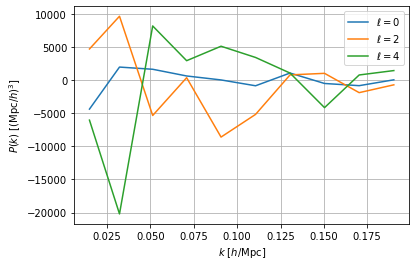

In [5]:
poles = result.poles
print('Shot noise is {:.4f}.'.format(poles.shotnoise)) # cross-correlation, shot noise is 0.
print('Normalization is {:.4f}.'.format(poles.wnorm))
ax = plt.gca()
for ill, ell in enumerate(poles.ells):
    # Calling poles() removes shotnoise for ell == 0 by default;
    # Pass remove_shotnoise = False if you do not want to;
    # See get_power() for all arguments
    ax.plot(*poles(ell=ell, return_k=True, complex=False), label=r'$\ell = {:d}$'.format(ell))
ax.legend()
ax.grid(True)
ax.set_xlabel(r'$k$ [$h/\mathrm{Mpc}$]')
ax.set_ylabel(r'$P(k)$ [$(\mathrm{Mpc}/h)^{3}$]')
plt.show()
# Zero power, as expected

In [6]:
# One can save the result
with tempfile.TemporaryDirectory() as tmp_dir:
    fn = os.path.join(tmp_dir, 'tmp.npy')
    result.save(fn)
    # And reload the result
    result = CatalogFFTPower.load(fn)
    print(result.poles.ells)
# One can also only save multipoles
with tempfile.TemporaryDirectory() as tmp_dir:
    fn = os.path.join(tmp_dir, 'tmp.npy')
    result.poles.save(fn)
    # And reload the result
    poles = PowerSpectrumStatistics.load(fn)
    print(poles.ells, type(poles))
# One can also export result as .txt (WARNING: this does not save all "poles" attributes, so there is not "load_txt" method)
with tempfile.TemporaryDirectory() as tmp_dir:
    fn = os.path.join(tmp_dir, 'tmp.txt')
    print('\n### real ###\n')
    # See get_power() for all arguments
    result.poles.save_txt(fn, header=['data_file1 = data1.fits', 'data_file2 = data2.fits'], complex=False)
    with open(fn, 'r') as file:
        for iline in range(25):
            print(next(file)[:-1])
    # Let's check saved result
    tmp = np.loadtxt(fn, unpack=True)
    assert np.allclose(tmp[3], result.poles(ell=0, complex=False), equal_nan=True)
    # Saving full complex numbers
    print('\n### complex ###\n')
    result.poles.save_txt(fn, header=['data_file1 = data1.fits', 'data_file2 = data2.fits'], complex=True)
    with open(fn, 'r') as file:
        for iline in range(25):
            print(next(file)[:-1])
    # Let's check saved result
    tmp = np.loadtxt(fn, unpack=True, dtype=np.complex_)
    assert np.allclose(tmp[4], result.poles(ell=2, complex=True), equal_nan=True)

[000012.48]  07-07 09:46  CatalogFFTPower              INFO     Saving /tmp/tmpa2r8hm_t/tmp.npy.
[000012.48]  07-07 09:46  CatalogFFTPower              INFO     Loading /tmp/tmpa2r8hm_t/tmp.npy.
(0, 2, 4)
[000012.48]  07-07 09:46  PowerSpectrumMultipoles      INFO     Saving /tmp/tmpc2d038j4/tmp.npy.
[000012.49]  07-07 09:46  PowerSpectrumStatistics      INFO     Loading /tmp/tmpc2d038j4/tmp.npy.
(0, 2, 4) <class 'pypower.fft_power.PowerSpectrumMultipoles'>

### real ###

[000012.50]  07-07 09:46  PowerSpectrumMultipoles      INFO     Saving /tmp/tmp9j6y5hy2/tmp.txt.
# data_file1 = data1.fits
# data_file2 = data2.fits
# autocorr = False
# data_size1 = 10000
# data_size2 = 10000
# sum_data_weights1 = 7.493566915134e+03
# sum_data_weights2 = 7.496122387445e+03
# randoms_size1 = 50000
# randoms_size2 = 50000
# sum_randoms_weights1 = 3.750816478469e+04
# sum_randoms_weights2 = 3.745845068475e+04
# los_type = firstpoint
# los = None
# nmesh = [128 128 128]
# boxsize = [2.000000000000e+03 2.

### Line-of-sight

[000012.62]  07-07 09:46  CatalogFFTPower              INFO     Painting catalog 1 to mesh CatalogMesh(nmesh=[128 128 128], boxsize=[2000. 2000. 2000.], boxcenter=[1499.9920812   500.00036096  500.02196033], dtype=float64).
[000012.64]  07-07 09:46  CatalogMesh                  INFO     Slab 0 ~ 4194304 / 10000.
[000012.75]  07-07 09:46  CatalogMesh                  INFO     Painted 10000 out of 10000 objects to mesh.
[000012.76]  07-07 09:46  CatalogMesh                  INFO     Slab 0 ~ 4194304 / 50000.
[000012.93]  07-07 09:46  CatalogMesh                  INFO     Painted 50000 out of 50000 objects to mesh.
[000012.93]  07-07 09:46  CatalogMesh                  INFO     Running interlacing at order 2.
[000013.01]  07-07 09:46  CatalogMesh                  INFO     Slab 0 ~ 4194304 / 10000.
[000013.12]  07-07 09:46  CatalogMesh                  INFO     Painted 10000 out of 10000 objects to mesh.
[000013.13]  07-07 09:46  CatalogMesh                  INFO     Slab 0 ~ 4194304 / 500

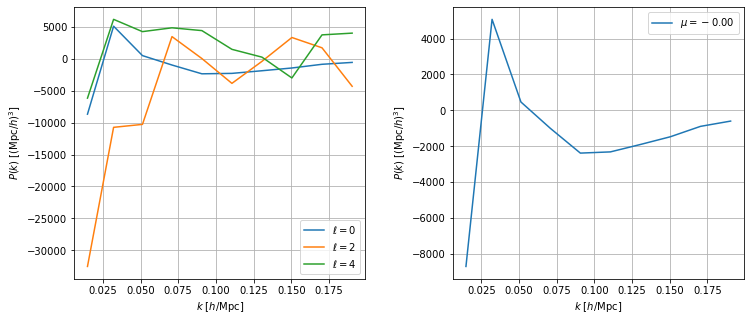

[000022.74]  07-07 09:46  PowerSpectrumWedges          INFO     Saving /tmp/tmpfjt3jgp9/tmp.txt.
# data_file1 = data1.fits
# data_file2 = data2.fits
# autocorr = True
# data_size1 = 10000
# data_size2 = 10000
# sum_data_weights1 = 7.493566915134e+03
# sum_data_weights2 = 7.493566915134e+03
# randoms_size1 = 50000
# randoms_size2 = 50000
# sum_randoms_weights1 = 3.750816478469e+04
# sum_randoms_weights2 = 3.750816478469e+04
# los_type = global
# los = [1.000000000000e+00 0.000000000000e+00 0.000000000000e+00]
# nmesh = [128 128 128]
# boxsize = [2.000000000000e+03 2.000000000000e+03 2.000000000000e+03]
# boxcenter = [1.499992081204e+03 5.000003609569e+02 5.000219603290e+02]
# resampler1 = tsc
# resampler2 = tsc
# interlacing1 = 2
# interlacing2 = 2
# shotnoise = 1.245954218613e+05
# wnorm = 5.609179773085e-02
# nmodes kmid               kavg               mumid              muavg               P(k,mu)
1045     1.000000000000e-02 1.483431797705e-02 0.000000000000e+00 6.799452016843e-18  

In [7]:
# By default (above), line-of-sight is 'firstpoint'
# Compute the power spectrum, using 'endpoint' line-of-sight
result = CatalogFFTPower(data_positions1=data_positions1, data_weights1=data_weights1,
                         randoms_positions1=randoms_positions1, randoms_weights1=randoms_weights1,
                         edges=kedges, ells=ells, interlacing=2, boxsize=2000., nmesh=128, resampler='tsc',
                         los='endpoint', position_type='xyz', mpiroot=0)

# Compute the power spectrum, using 'x' line-of-sight
result = CatalogFFTPower(data_positions1=data_positions1, data_weights1=data_weights1,
                         randoms_positions1=randoms_positions1, randoms_weights1=randoms_weights1,
                         edges=kedges, ells=ells, interlacing=2, boxsize=2000., nmesh=128, resampler='tsc',
                         los='x', position_type='xyz', mpiroot=0)
# In addition to "poles", one has access to "wedges"

poles = result.poles
wedges = result.wedges
fig, lax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
fig.subplots_adjust(wspace=0.3)
lax = lax.flatten()
for ill, ell in enumerate(poles.ells):
    # Shot noise removed
    lax[0].plot(*poles(ell=ell, return_k=True, complex=False), label=r'$\ell = {:d}$'.format(ell))
# With global line-of-sight, we also have wedges
for imu, mu in enumerate(wedges.muavg):
    # Shot noise removed
    lax[1].plot(*wedges(mu=mu, return_k=True, complex=False), label=r'$\mu = {:.2f}$'.format(mu))
for ax in lax:
    ax.legend()
    ax.grid(True)
    ax.set_xlabel(r'$k$ [$h/\mathrm{Mpc}$]')
    ax.set_ylabel(r'$P(k)$ [$(\mathrm{Mpc}/h)^{3}$]')
plt.show()
# Zero power, as expected

# One can also export result as .txt (WARNING: this does not save all "wedges" attributes, so there is not "load_txt" method)
with tempfile.TemporaryDirectory() as tmp_dir:
    fn = os.path.join(tmp_dir, 'tmp.txt')
    # See get_power() for all arguments
    result.wedges.save_txt(fn, header=['data_file1 = data1.fits', 'data_file2 = data2.fits'], complex=False)
    with open(fn, 'r') as file:
        for iline in range(25):
            print(next(file)[:-1])
    # Let's check saved result
    tmp = np.loadtxt(fn, unpack=True)
    assert np.allclose(tmp[5], result.wedges(mu=result.wedges.modeavg(axis=1, method='mid')[0], complex=False), equal_nan=True)

### Residual

[000022.86]  07-07 09:46  CatalogFFTResidual           INFO     Painting catalog 1 to mesh CatalogMesh(nmesh=[128 128 128], boxsize=[2000. 2000. 2000.], boxcenter=[1499.9920812   500.00036096  500.02196033], dtype=float64).
[000022.86]  07-07 09:46  CatalogMesh                  INFO     Slab 0 ~ 4194304 / 10000.
[000023.00]  07-07 09:46  CatalogMesh                  INFO     Painted 10000 out of 10000 objects to mesh.
[000023.00]  07-07 09:46  CatalogMesh                  INFO     Slab 0 ~ 4194304 / 50000.
[000023.16]  07-07 09:46  CatalogMesh                  INFO     Painted 50000 out of 50000 objects to mesh.
[000023.17]  07-07 09:46  CatalogMesh                  INFO     Running interlacing at order 2.
[000023.26]  07-07 09:46  CatalogMesh                  INFO     Slab 0 ~ 4194304 / 10000.
[000023.39]  07-07 09:46  CatalogMesh                  INFO     Painted 10000 out of 10000 objects to mesh.
[000023.40]  07-07 09:46  CatalogMesh                  INFO     Slab 0 ~ 4194304 / 500

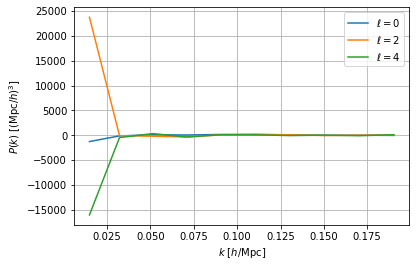

In [8]:
# "residual" estimator, computing (D - R) * R (in case shifted catalog is provided, this is (D - S) * R)
from pypower import CatalogFFTResidual
kedges = np.linspace(0, 0.2, 11)
ells = (0, 2, 4)
result_residual = CatalogFFTResidual(data_positions1=data_positions1, data_weights1=data_weights1,
                                     randoms_positions1=randoms_positions1, randoms_weights1=randoms_weights1,
                                     edges=kedges, ells=ells, interlacing=2, boxsize=2000., nmesh=128, resampler='tsc',
                                     los=None, position_type='xyz', mpiroot=0)
poles = result_residual.poles
ax = plt.gca()
for ill, ell in enumerate(poles.ells):
    # Shot noise removed
    ax.plot(*poles(ell=ell, return_k=True, complex=False), label=r'$\ell = {:d}$'.format(ell))
ax.set_xlabel(r'$k$ [$h/\mathrm{Mpc}$]')
ax.set_ylabel(r'$P(k)$ [$(\mathrm{Mpc}/h)^{3}$]')
ax.grid(True)
ax.legend()
plt.show()

### Reconstruction

In [9]:
# In case of reconstruction, using shifted catalogs random catalogs (here we just use the same)
# This will compute the power spectrum of D - S, normalized using R.
# See https://github.com/cosmodesi/pyrecon/blob/main/nb/e2e_examples.ipynb
shifted_positions1, shifted_weights1 = randoms_positions1, randoms_weights1
kedges = np.linspace(0, 0.2, 11)
ells = (0, 2, 4)
result = CatalogFFTPower(data_positions1=data_positions1, data_weights1=data_weights1,
                         randoms_positions1=randoms_positions1, randoms_weights1=randoms_weights1,
                         shifted_positions1=shifted_positions1, shifted_weights1=shifted_weights1,
                         edges=kedges, ells=ells, interlacing=2, boxsize=2000., nmesh=128, resampler='tsc',
                         los=None, position_type='xyz', mpiroot=0)

[000028.42]  07-07 09:46  CatalogFFTPower              INFO     Painting catalog 1 to mesh CatalogMesh(nmesh=[128 128 128], boxsize=[2000. 2000. 2000.], boxcenter=[1499.9920812   500.00036096  500.02196033], dtype=float64).
[000028.43]  07-07 09:46  CatalogMesh                  INFO     Slab 0 ~ 4194304 / 10000.
[000028.53]  07-07 09:46  CatalogMesh                  INFO     Painted 10000 out of 10000 objects to mesh.
[000028.53]  07-07 09:46  CatalogMesh                  INFO     Slab 0 ~ 4194304 / 50000.
[000028.65]  07-07 09:46  CatalogMesh                  INFO     Painted 50000 out of 50000 objects to mesh.
[000028.65]  07-07 09:46  CatalogMesh                  INFO     Running interlacing at order 2.
[000028.71]  07-07 09:46  CatalogMesh                  INFO     Slab 0 ~ 4194304 / 10000.
[000028.80]  07-07 09:46  CatalogMesh                  INFO     Painted 10000 out of 10000 objects to mesh.
[000028.81]  07-07 09:46  CatalogMesh                  INFO     Slab 0 ~ 4194304 / 500

## Catalog mesh
Internally, CatalogFFTPower build one (two if cross-power) CatalogMesh instances (with same mesh) and pass them to MeshFFTPower.

In [10]:
# Here we let it choose the box size
mesh1 = CatalogMesh(data_positions=data_positions1, data_weights=data_weights1,
                    randoms_positions=randoms_positions1, randoms_weights=randoms_weights1,
                    interlacing=2, boxsize=None, nmesh=128, resampler='tsc', position_type='xyz', mpiroot=0)
# Here again, for uniform selection function, just do not provide randoms
# Here we provide global line-of-sight and mu-edges
muedges = np.linspace(-1., 1., 4)
result = MeshFFTPower(mesh1, edges=(kedges, muedges), los='z')

[000032.07]  07-07 09:47  MeshFFTPower                 INFO     Painting catalog 1 to mesh CatalogMesh(nmesh=[128 128 128], boxsize=[1999.94622506 1999.94622506 1999.94622506], boxcenter=[1499.9920812   500.00036096  500.02196033], dtype=float64).
[000032.08]  07-07 09:47  CatalogMesh                  INFO     Slab 0 ~ 4194304 / 10000.
[000032.17]  07-07 09:47  CatalogMesh                  INFO     Painted 10000 out of 10000 objects to mesh.
[000032.18]  07-07 09:47  CatalogMesh                  INFO     Slab 0 ~ 4194304 / 50000.
[000032.30]  07-07 09:47  CatalogMesh                  INFO     Painted 50000 out of 50000 objects to mesh.
[000032.30]  07-07 09:47  CatalogMesh                  INFO     Running interlacing at order 2.
[000032.36]  07-07 09:47  CatalogMesh                  INFO     Slab 0 ~ 4194304 / 10000.
[000032.45]  07-07 09:47  CatalogMesh                  INFO     Painted 10000 out of 10000 objects to mesh.
[000032.45]  07-07 09:47  CatalogMesh                  INFO   

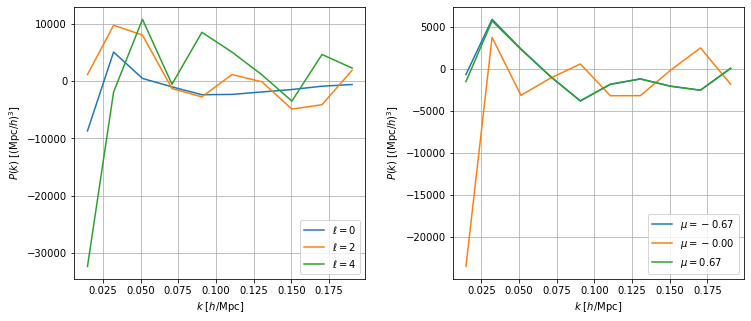

In [11]:
poles = result.poles
wedges = result.wedges
fig, lax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
fig.subplots_adjust(wspace=0.3)
lax = lax.flatten()
for ill, ell in enumerate(poles.ells):
    # Shot noise removed
    lax[0].plot(*poles(ell=ell, return_k=True, complex=False), label=r'$\ell = {:d}$'.format(ell))
# With global line-of-sight, we also have wedges
for imu, mu in enumerate(wedges.muavg):
    # Shot noise removed
    lax[1].plot(*wedges(mu=mu, return_k=True, complex=False), label=r'$\mu = {:.2f}$'.format(mu))
for ax in lax:
    ax.legend()
    ax.grid(True)
    ax.set_xlabel(r'$k$ [$h/\mathrm{Mpc}$]')
    ax.set_ylabel(r'$P(k)$ [$(\mathrm{Mpc}/h)^{3}$]')
plt.show()
# Zero power, as expected

## Rebinning
We provide methods to rebin power spectrum estimation accurately, i.e. taking the number of $k$-modes into account.

In [12]:
poles2 = poles[::2]
print('Initial k-modes {}.'.format(poles.kavg))
print('After rebinning {}.'.format(poles2.kavg))

Initial k-modes [0.01483472 0.03215042 0.05129251 0.07087069 0.09070497 0.11058973
 0.13047672 0.15038655 0.1703575  0.19034838].
After rebinning [0.0300727  0.06426886 0.10259729 0.14184564 0.18145079].


In [13]:
# Note that one can remove some bins such that the rebinning factor divides the shape
# Here we remove the last bin of the second axis before rebinning
wedges2 = wedges[::2,:-1:2]
print('Initial k-modes {}, mu-modes {}.'.format(wedges.kavg, wedges.muavg))
print('After rebinning {}, {}.'.format(wedges2.kavg, wedges2.muavg))
# Usually, one would like to remove the remainder last bins
factor = 6
rebinned = poles[:(poles.shape[0] // factor) * factor:factor]

Initial k-modes [0.01483472 0.03215042 0.05129251 0.07087069 0.09070497 0.11058973
 0.13047672 0.15038655 0.1703575  0.19034838], mu-modes [-6.66912929e-01 -1.21998220e-04  6.66790655e-01].
After rebinning [0.03008018 0.06428116 0.10260415 0.14183939 0.18144892], [-0.33320194].


In [14]:
# You can also select some range
kavg, muavg = wedges.kavg, wedges.muavg
print('Initially k in [{}, {}], mu in [{}, {}].'.format(kavg.min(), kavg.max(), muavg.min(), muavg.max()))
wedges.select((0, 0.07), (-1., 0))
kavg, muavg = wedges.kavg, wedges.muavg
print('After selection k in [{}, {}], mu in [{}, {}].'.format(kavg.min(), kavg.max(), muavg.min(), muavg.max()))

Initially k in [0.014834716845057945, 0.1903483846340751], mu in [-0.666912929343983, 0.6667906545268477].
After selection k in [0.01483394075943182, 0.05131403914262816], mu in [-0.6684573673434536, -0.0010927842092681777].


### Combining power spectrum estimation in two regions (typically N & S)

[000033.95]  07-07 09:47  CatalogFFTPower              INFO     Painting catalog 1 to mesh CatalogMesh(nmesh=[128 128 128], boxsize=[2000. 2000. 2000.], boxcenter=[1499.9920812   500.00036096  500.02196033], dtype=float64).
[000033.96]  07-07 09:47  CatalogMesh                  INFO     Slab 0 ~ 4194304 / 10000.
[000034.07]  07-07 09:47  CatalogMesh                  INFO     Painted 10000 out of 10000 objects to mesh.
[000034.07]  07-07 09:47  CatalogMesh                  INFO     Slab 0 ~ 4194304 / 50000.
[000034.18]  07-07 09:47  CatalogMesh                  INFO     Painted 50000 out of 50000 objects to mesh.
[000034.18]  07-07 09:47  CatalogMesh                  INFO     Running interlacing at order 2.
[000034.25]  07-07 09:47  CatalogMesh                  INFO     Slab 0 ~ 4194304 / 10000.
[000034.35]  07-07 09:47  CatalogMesh                  INFO     Painted 10000 out of 10000 objects to mesh.
[000034.35]  07-07 09:47  CatalogMesh                  INFO     Slab 0 ~ 4194304 / 500

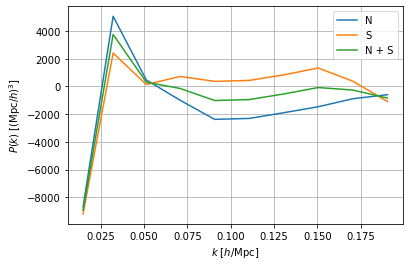

In [15]:
poles_N = CatalogFFTPower(data_positions1=data_positions1, data_weights1=data_weights1,
                          randoms_positions1=randoms_positions1, randoms_weights1=randoms_weights1,
                          edges=kedges, ells=ells, interlacing=2, boxsize=2000., nmesh=128, resampler='tsc',
                          los='endpoint', position_type='xyz', mpiroot=0).poles
poles_S = CatalogFFTPower(data_positions1=data_positions2, data_weights1=data_weights2,
                          randoms_positions1=randoms_positions2, randoms_weights1=randoms_weights2,
                          edges=kedges, ells=ells, interlacing=2, boxsize=2000., nmesh=128, resampler='tsc',
                          los='endpoint', position_type='xyz', mpiroot=0).poles

# To average the power spectra weighted by their wnorm:
poles_NS = poles_N + poles_S

ax = plt.gca()
ax.plot(*poles_N(ell=0, return_k=True, complex=False), label='N')
ax.plot(*poles_S(ell=0, return_k=True, complex=False), label='S')
ax.plot(*poles_NS(ell=0, return_k=True, complex=False), label='N + S')
ax.set_xlabel(r'$k$ [$h/\mathrm{Mpc}$]')
ax.set_ylabel(r'$P(k)$ [$(\mathrm{Mpc}/h)^{3}$]')
ax.grid(True)
ax.legend()
plt.show()

## MPI
**pypower** is MPI-parallelized. Below is an example script.

In [16]:
base_dir = '_tests'
utils.mkdir(base_dir)

In [17]:
%%file '_tests/script.py'

import os

import numpy as np
import fitsio

from pypower import CatalogFFTPower, mpi, setup_logging

# To activate logging
setup_logging()

base_dir = os.path.join('..', 'pypower', 'tests', 'catalog')
data_fn = os.path.join(base_dir, 'lognormal_data.fits')

mpicomm = mpi.COMM_WORLD
kedges = np.linspace(0, 0.2, 41)

# Read input catalogs, scattering on all MPI ranks (1 in this notebook)
def read(fn, columns=('Position', 'WEIGHT_FKP'), ext=1):
    csize = fitsio.FITS(fn)[ext].get_nrows()
    start, stop = mpicomm.rank * csize // mpicomm.size, (mpicomm.rank + 1) * csize // mpicomm.size
    tmp = fitsio.read(fn, ext=ext, columns=columns, rows=range(start, stop))
    return [tmp[col] for col in columns]
    # Alternatively, you can use mpytools
    #from mpytools import Catalog
    #catalog = Catalog.read(fn, ext=ext, mpicomm=mpicomm)
    #return [catalog[col] for col in columns]

data_positions, data_weights = read(data_fn)
mpiroot = None # input positions/weights scattered on all processes
"""
# Alternatively, if you do not want to read catalog on process 0:
mpiroot = 0
# We read catalog on a single process
if mpicomm.rank == mpiroot:
    file = fitsio.read(data_fn)
    data_positions, data_weights = file['Position'], file['WEIGHT_FKP']
else:
    data_positions, data_weights = None, None
"""
power = CatalogFFTPower(data_positions1=data_positions, data_weights1=data_weights, nmesh=128, boxsize=600., boxcenter=0.,
                        resampler='tsc', interlacing=3, ells=(0, 2, 4), los='x', edges=(kedges, np.linspace(-1., 1., 5)),
                        position_type='pos', mpicomm=mpicomm, mpiroot=mpiroot, dtype='f4')

base_dir = '_tests'
fn = os.path.join(base_dir, 'power.npy')
power.save(fn)

Overwriting _tests/script.py


In [18]:
%%bash
mpiexec -np 4 python _tests/script.py

[000000.10]  07-07 09:47  CatalogFFTPower              INFO     Painting catalog 1 to mesh CatalogMesh(nmesh=[128 128 128], boxsize=[600. 600. 600.], boxcenter=[0. 0. 0.], dtype=float32).
[000000.12]  07-07 09:47  CatalogMesh                  INFO     Slab 0 ~ 4194304 / 214892.
[000000.27]  07-07 09:47  CatalogMesh                  INFO     Painted 214892 out of 214892 objects to mesh.
[000000.27]  07-07 09:47  CatalogMesh                  INFO     Running interlacing at order 3.
[000000.32]  07-07 09:47  CatalogMesh                  INFO     Slab 0 ~ 4194304 / 214892.
[000000.48]  07-07 09:47  CatalogMesh                  INFO     Painted 214892 out of 214892 objects to mesh.
[000000.57]  07-07 09:47  CatalogMesh                  INFO     Slab 0 ~ 4194304 / 214892.
[000000.71]  07-07 09:47  CatalogMesh                  INFO     Painted 214892 out of 214892 objects to mesh.
[000000.83]  07-07 09:47  CatalogFFTPower              INFO     Done painting catalog 1 to mesh.
[000000.83]  07-

In [19]:
!ls -l _tests

total 20
-rw-r----- 1 adematti idphp 16085 Jul  7 09:47 power.npy
-rw-r----- 1 adematti idphp  1725 Jul  7 09:47 script.py


In [20]:
power = CatalogFFTPower.load(os.path.join(base_dir, 'power.npy'))
poles = power.poles
print('Shot noise is {:.4f}.'.format(poles.shotnoise))
print('Normalization is {:.4f}.'.format(poles.wnorm))

[000044.68]  07-07 09:47  CatalogFFTPower              INFO     Loading _tests/power.npy.
Shot noise is 1005.1561.
Normalization is 213.7897.


## Plotting
There is a simple plotting function for basic plots.

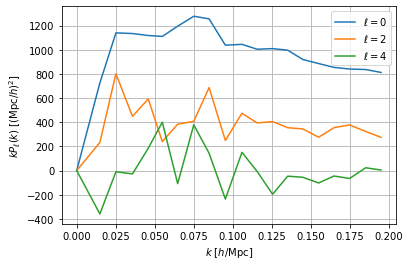

In [21]:
poles[::2].plot(show=True);

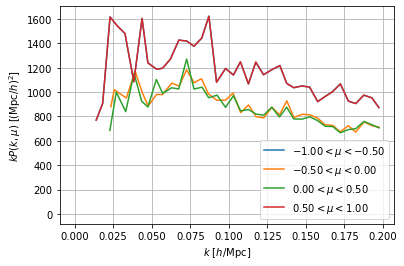

In [22]:
power.wedges.plot(show=True);